# Модель анализа комментариев для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Нам необходимо обучить модель классифицировать комментарии на позитивные и негативные. 

В нашем распоряжении набор данных с разметкой о токсичности правок.

Задача - построить модель со значением метрики качества *F1* не меньше 0.75.
    
 
    
____



В данном исследовании представлен процесс создания и проверки моделей машинного обучения в целях прогнозирования заказов. Работа произведена в соответствии с инструкциями заказчика. Каждый значительный шаг сопровождается промежуточным, либо общим выводом.
 
    
    
____
    

    
    
    
Часть 1. Изучение общей информации о предоставленном датасете
    
1. Импорт необходимых библиотек для работы с данными, загрузка датасета
2. Изучение данных, получение общей информации
3. Вывод

Часть 2. Подготовка данных

1. Создание инструментов подготовки данных
2. Применение созданных функций
3. Вывод
    
Часть 3. Обучение моделей
    
1. Подготовительные мероприятия
2. Обучение моделей
3. Вывод
    

 ## Часть 1. Изучение общей информации о предоставленном датасете

<a id='Импорт необходимых библиотек для работы с данными, загрузка датасета'>

### <p style="text-align:center"> Импорт необходимых библиотек для работы с данными, загрузка датасета</p>

Импортируем необходимые библиотеки, убираем ограничения на количество столбцов, отключаем предупреждения.

In [1]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import re
import nltk
import timeit
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

In [4]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

Загружаем датасет, проверяем вывод.

In [5]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [6]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


<a id='Изучение данных, получение общей информации'></a>

### <p style="text-align:center"> Изучение данных, получение общей информации</p>

Ознакомимся с информацией, посмотрим соответствуют ли типы ячеек назначению. В качестве дополнительной проверки возьмем случайные 20 строк из нашего датасета, посмотрим на странные, выбивающиеся, отсутствующие значения.

In [7]:
data.sample(n=20, random_state=1)

,text,toxic
24915,"YOU ARE A FAT, GEEKY PRICK WHO HAS NOTHING TO ...",1
75819,Agent X2: Basically thanks - with a 'little' m...,0
53891,Why are my posts being deleted? \n\nI have tri...,0
154159,"""\n\n Controlled Demolitions and Common Sense ...",0
13040,I do not understand your reply. //Blaxthos ( ...,0
123190,Is this the bizarro world? Removing content is...,0
33626,"Well, WP:RS says that articles should use reli...",0
1150,Oh hear me go someone removes all my pages i g...,0
48633,can't believe this article was deleted\nI'm su...,0
42817,"""\n\n Comments on GamerGate Workshop page \n\n...",0


Иногда в таблицах в конце есть строка "Итого"(или т.п.), нам она не нужна, убедимся в ее отсутствии.

In [8]:
data.tail()

,text,toxic
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0
159570,"""\nAnd ... I really don't think you understand...",0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [10]:
data.describe()

,toxic
count,159571.000000
mean,0.101679
std,0.302226
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Посмотрим на баланс классов.

In [11]:
data['toxic'].value_counts(normalize=True)

0    0.898321
1    0.101679
Name: toxic, dtype: float64

Выведем наиболее часто встречающиеся слова по категориям.

(-0.5, 399.5, 199.5, -0.5)

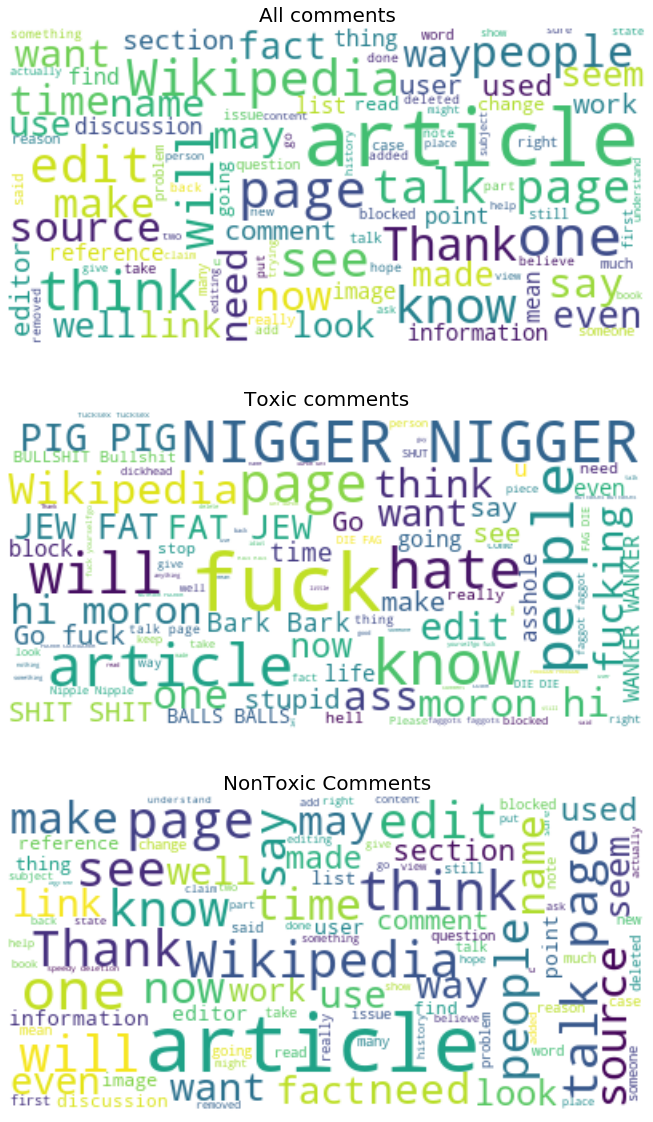

In [12]:
df_toxic = data[data['toxic']==1]
df_not_toxic = data[data['toxic']==0]

All = " ".join(review for review in data.text)
toxic = " ".join(review for review in df_toxic.text)
not_toxic = " ".join(review for review in df_not_toxic.text)

fig, ax = plt.subplots(3, 1, figsize  = (20,20))
wordcloud_all = WordCloud(max_font_size=50, max_words=100, background_color='white').generate(All)
wordcloud_toxic = WordCloud(max_font_size=50, max_words=100, background_color='white').generate(toxic)
wordcloud_not_toxic = WordCloud(max_font_size=50, max_words=100, background_color='white').generate(not_toxic)


ax[0].imshow(wordcloud_all, interpolation='bilinear')
ax[0].set_title('All comments', fontsize=20)
ax[0].axis('off')
ax[1].imshow(wordcloud_toxic, interpolation='bilinear')
ax[1].set_title('Toxic comments',fontsize=20)
ax[1].axis('off')
ax[2].imshow(wordcloud_not_toxic, interpolation='bilinear')
ax[2].set_title('NonToxic Comments',fontsize=20)
ax[2].axis('off')

<a id='Вывод_1'></a>

### <p style="text-align:center"> Вывод</p>

##### В ходе первичного анализа данных были  сделаны следующие выводы:

___


1. Предоставлено около 160 тысяч комментариев с разметкой о токсичности.


2. Необходима подготовка комментариев - приведение к одному виду, лемматизация, удаление лишних символов.


3. Наблюдаем сильный дисбаланс классов.
___

Таким образом было выполнено первичное ознакомление с предоставленной информацией, выявлены некоторые дефекты датасета. Данные нуждаются в предобработке. Можно переходить к подготовке данных.

 ## Часть 2. Подготовка данных

<a id='Создание инструментов подготовки данных'></a>

### <p style="text-align:center"> Создание инструментов подготовки данных </p>

Создадам несколько функций для подготовки наших данных.

In [13]:
def get_clean(text):
    t = re.sub(r'[^A-Za-z]', ' ', text) 
    return " ".join(t.split())

In [14]:
lemmatizer = WordNetLemmatizer()

def get_lemm(word_list):
    lemmatized_output = ' '.join([lemmatizer.lemmatize(word, pos="v") for word in word_list])
    return lemmatized_output

In [15]:
def get_token(text):
    text = re.split('\W+', text)
    return text

In [16]:
stop_words = nltk.corpus.stopwords.words('english')

def remove_stopwords(word_list):
    text = [word for word in word_list if word not in stopword]
    return text

In [17]:
stop_words = set(nltk.corpus.stopwords.words('english'))

def removes_stopwords(word_list):
    word_tokens = word_tokenize(word_list)
    filtered_sentence = [word for word in word_tokens if not word.lower() in stop_words]
    filtered_sentence = []
    for word in word_tokens:
        if word not in stop_words:
            filtered_sentence.append(word)
    return ' '.join(filtered_sentence)

<a id='Применение созданных функций'></a>

### <p style="text-align:center"> Применение созданных функций </p>

In [18]:
data['cleaned'] = data['text'].apply(lambda x: get_clean(x))

In [19]:
data.head()

,text,toxic,cleaned
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...


In [20]:
data['tokenized'] = data['cleaned'].apply(lambda x: get_token(x))

In [21]:
data.head()

,text,toxic,cleaned,tokenized
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...,"[Explanation, Why, the, edits, made, under, my..."
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...,"[D, aww, He, matches, this, background, colour..."
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...,"[Hey, man, I, m, really, not, trying, to, edit..."
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on impr...,"[More, I, can, t, make, any, real, suggestions..."
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...,"[You, sir, are, my, hero, Any, chance, you, re..."


In [22]:
data['lemmatized'] = data['tokenized'].apply(lambda x: get_lemm(x))

In [23]:
data.head()

,text,toxic,cleaned,tokenized,lemmatized
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...,"[Explanation, Why, the, edits, made, under, my...",Explanation Why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...,"[D, aww, He, matches, this, background, colour...",D aww He match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...,"[Hey, man, I, m, really, not, trying, to, edit...",Hey man I m really not try to edit war It s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on impr...,"[More, I, can, t, make, any, real, suggestions...",More I can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...,"[You, sir, are, my, hero, Any, chance, you, re...",You sir be my hero Any chance you remember wha...


In [24]:
data['pure_cleaned'] = data['cleaned'].apply(lambda x: removes_stopwords(x))

In [25]:
data.head()

,text,toxic,cleaned,tokenized,lemmatized,pure_cleaned
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...,"[Explanation, Why, the, edits, made, under, my...",Explanation Why the edit make under my usernam...,Explanation Why edits made username Hardcore M...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...,"[D, aww, He, matches, this, background, colour...",D aww He match this background colour I m seem...,D aww He matches background colour I seemingly...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...,"[Hey, man, I, m, really, not, trying, to, edit...",Hey man I m really not try to edit war It s ju...,Hey man I really trying edit war It guy consta...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on impr...,"[More, I, can, t, make, any, real, suggestions...",More I can t make any real suggestions on impr...,More I make real suggestions improvement I won...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...,"[You, sir, are, my, hero, Any, chance, you, re...",You sir be my hero Any chance you remember wha...,You sir hero Any chance remember page


<a id='Вывод_2'></a>

### <p style="text-align:center"> Вывод</p>

##### В ходе подготовки данных были сделаны следующие шаги:

___


1. Создано несколько функций для создания дополнительных признаков.


2. Функции успешно применены.
___

Таким образом была выполнена подготовка данных. Можно переходить к обучению моделей.

 ## Часть 3. Обучение моделей

<a id='Подготовительные мероприятия'></a>

### <p style="text-align:center"> Подготовительные мероприятия </p>

In [26]:
train, test = train_test_split(data, test_size=0.3, random_state=42)

Создадим несколько моделей и TfidfVectorizer.

In [27]:
log_reg = LogisticRegression(class_weight='balanced', C=100)
lgbm_clf = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', num_iterations=100)
sgd = SGDClassifier()

In [28]:
count_tf_idf = TfidfVectorizer()

In [29]:
result_list = []

def calculate_metric(model_name):
    
    ''' Function calculates target metric and saves the results in pre-created result_list.'''
    
    features = ['cleaned', 'tokenized', 'lemmatized', 'pure_cleaned']
    
    for feature in features:
        X_train = train[feature]
        y_train = train['toxic']
        X_test = test[feature]
        y_test = test['toxic']
    
        train_corpus = X_train.astype('U')
        tfidf = count_tf_idf.fit_transform(train_corpus) 
        corpus_test = X_test.astype('U')
        tfidf_test = count_tf_idf.transform(corpus_test)
        
        model_name.fit(tfidf, y_train)     
        predictions = model_name.predict(tfidf_test)
        result_list.append({
            'model': str(model_name),
            'feature': feature,
            'f1_score': f1_score(y_test, predictions),
        })

<a id='Обучение моделей'></a>

### <p style="text-align:center"> Обучение моделей </p>

In [30]:
start = timeit.default_timer()

calculate_metric(log_reg)

stop = timeit.default_timer()
print(f'Время обучения логистической регрессии - {(stop-start):.2f} секунд.')

Время обучения логистической регрессии - 201.29 секунд.


In [31]:
start = timeit.default_timer()

calculate_metric(lgbm_clf)

stop = timeit.default_timer()
print(f'Время обучения Light Gradient Boosting Machine - {(stop-start):.2f} секунд.')

Время обучения Light Gradient Boosting Machine - 685.47 секунд.


In [32]:
start = timeit.default_timer()

calculate_metric(sgd)

stop = timeit.default_timer()
print(f'Время обучения Stochastic Gradient Descent  - {(stop-start):.2f} секунд.')

Время обучения Stochastic Gradient Descent  - 30.10 секунд.


In [33]:
results = pd.DataFrame(result_list, columns=['model', 'feature', 'f1_score'])
results

,model,feature,f1_score
0,"LogisticRegression(C=100, class_weight='balanc...",cleaned,0.770487
1,"LogisticRegression(C=100, class_weight='balanc...",tokenized,0.770487
2,"LogisticRegression(C=100, class_weight='balanc...",lemmatized,0.765627
3,"LogisticRegression(C=100, class_weight='balanc...",pure_cleaned,0.767854
4,"LGBMClassifier(boosting_type='gbdt', class_wei...",cleaned,0.757338
5,"LGBMClassifier(boosting_type='gbdt', class_wei...",tokenized,0.757338
6,"LGBMClassifier(boosting_type='gbdt', class_wei...",lemmatized,0.757174
7,"LGBMClassifier(boosting_type='gbdt', class_wei...",pure_cleaned,0.748792
8,"SGDClassifier(alpha=0.0001, average=False, cla...",cleaned,0.617099
9,"SGDClassifier(alpha=0.0001, average=False, cla...",tokenized,0.619932


<a id='Вывод_3'></a>

### <p style="text-align:center"> Вывод</p>

##### В ходе первичного анализа данных были  сделаны следующие выводы:

___


1. Обучены модели LogisticRegression, LGBMClassifier и SGDClassifier.


2. Наилучшей моделью показала себя модель LogisticRegression, модель LGBMClassifier имеет пространство для улучшения с практически одинаковым с предыдущей моделью результатом. SGDClassifier не прошел порог качества.
___

Таким образом было выполнено обучение моделей на основе предоставленной информации, LogisticRegression и LGBMClassifier прошли проверку качества и могут быть как улучшены, так и использованы в бизнес-целях.